In [1]:
import csv
import json
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pickle

csvFilePath = 'training\simulated_data.csv'
jsonFilePath = 'json\simulated_data.json'
data = {}

# for wells set to 0 / for simulated data set to 1
i = 1

In [2]:

# Load the JSON file
with open(jsonFilePath) as dataFile:
    data = json.load(dataFile)

In [3]:
data = data["1"]

In [4]:
# load the pretrained model 
if i == 0:
    with open("ModelTimeSeriesWells.pkl","rb") as f:
        model = pickle.load(f)
    with open("Model.pkl","rb") as f:
        detector=pickle.load(f)
    with open("PCA_Transform.pkl","rb") as f:
        pca=pickle.load(f)
    with open("Scalar.pkl","rb") as f:
        scalar=pickle.load(f)
else:
    with open("ModelTimeSeriesSimulated_data.pkl","rb") as f:
        model = pickle.load(f)
    with open("Model.pkl","rb") as f:
        detector=pickle.load(f)
    with open("PCA_Transform.pkl","rb") as f:
        pca=pickle.load(f)
    with open("Scalar.pkl","rb") as f:
        scalar=pickle.load(f)

In [5]:
df_json = data

row=pd.Series(df_json)[["Drive Frequency","Average Amps","Discharge Pressure","Intake Pressure","Intake Temperature","Motor Temperature"]].values
df0=pd.Series(df_json)[["Drive Frequency","Average Amps","Discharge Pressure","Intake Pressure","Intake Temperature","Motor Temperature"]].values
row=np.array(row,dtype="float32").reshape(1,-1)
predictiontemp = detector.predict(pca.transform(scalar.transform(row)))
predictiontemp[0]

1

In [6]:
df00 = pd.DataFrame(data=row,columns=["Drive Frequency","Average Amps","Discharge Pressure","Intake Pressure","Intake Temperature","Motor Temperature"])

In [7]:
dates=pd.date_range(start="2021-06-01",end="2021-06-21",periods=10)
df00["Time"] = str(dates[3])

In [8]:
df00 = df00.set_index("Time")

In [9]:
df00

,Drive Frequency,Average Amps,Discharge Pressure,Intake Pressure,Intake Temperature,Motor Temperature
Time,,,,,,
2021-06-07 16:00:00,52.900002,38.5,652.409973,1370.949951,61.900002,84.800003


There is no outlier in Drive Frequency

There is no outlier in Average Amps

There are total 1 outliers in Discharge Pressure columns


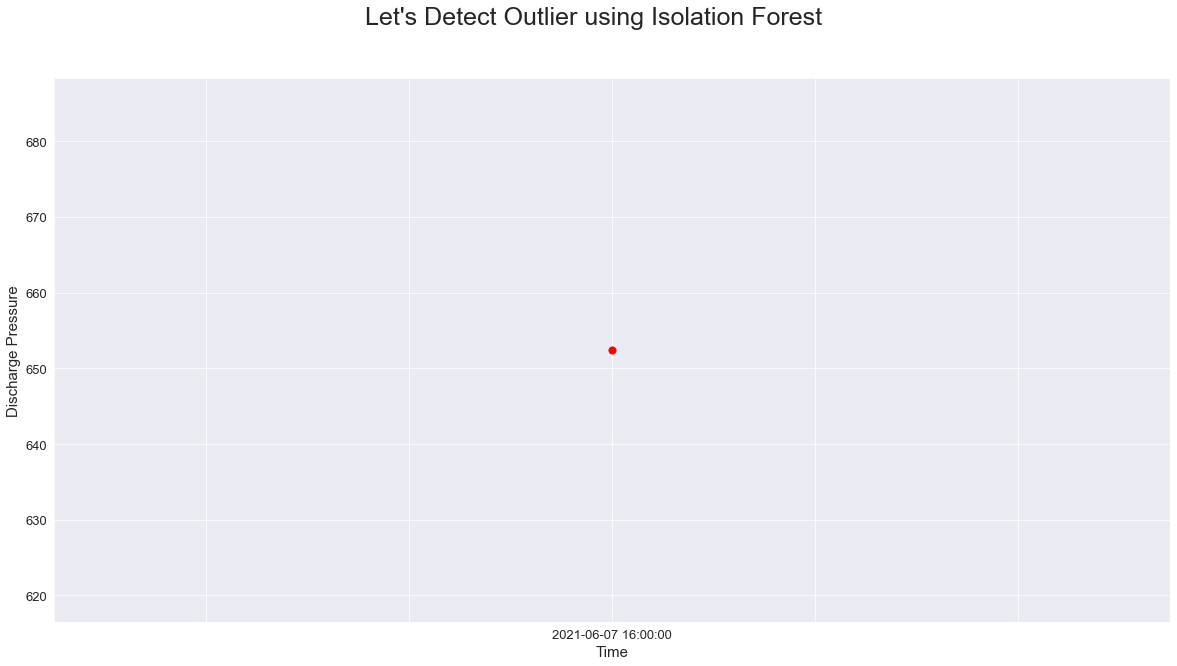

There are total 1 outliers in Intake Pressure columns


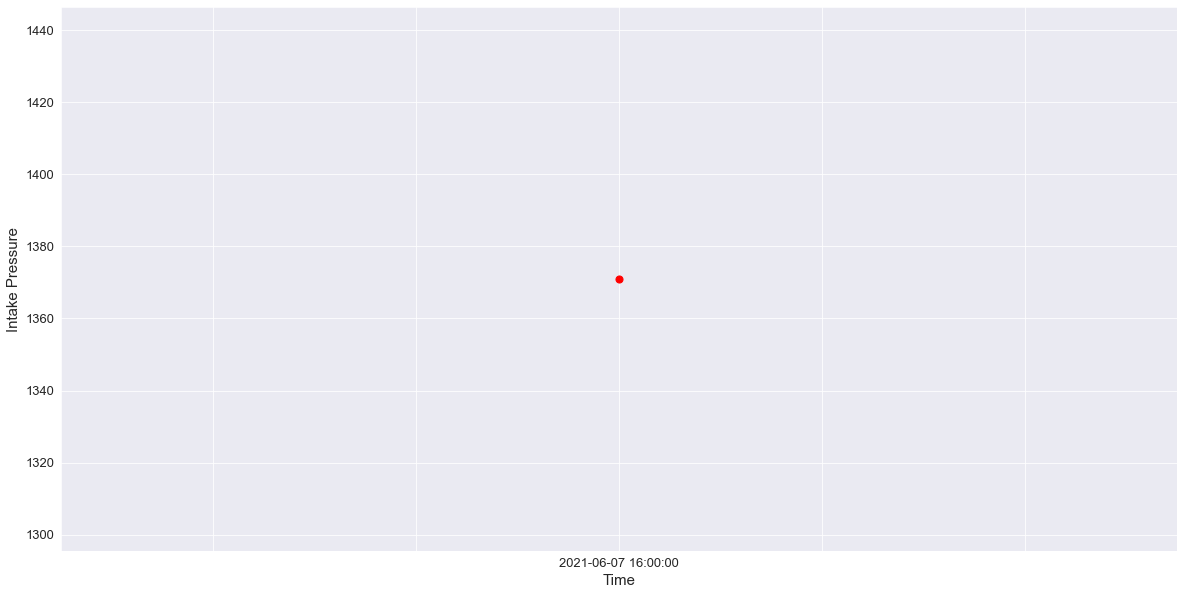

There is no outlier in Intake Temperature

There is no outlier in Motor Temperature



In [10]:
plt.suptitle("Let's Detect Outlier using Isolation Forest",fontsize=25)
dfTimeSeries = df00.copy()
for col in df00.columns:
    p=model.predict(df00[col].values.reshape(-1,1))
    temp=df00[p==-1][col]
    dfTimeSeries[f"{col} anomaly"] = p
 
    
    if len(temp)> 0:
        print(f"There are total {len(temp)} outliers in {col} columns")
        df00[col].plot(figsize=(20,10),fontsize=13,color="green")
        plt.scatter(x=temp.index,y=temp.values,s=50,c="red",alpha=1)
        plt.ylabel(col,fontsize=15)
        plt.xlabel("Time",fontsize=15)
        plt.show()
    else:
        print(f"There is no outlier in {col}\n")


In [11]:
# df00

,Drive Frequency,Average Amps,Discharge Pressure,Intake Pressure,Intake Temperature,Motor Temperature
Time,,,,,,
2021-06-07 16:00:00,52.900002,38.5,652.409973,1370.949951,61.900002,84.800003


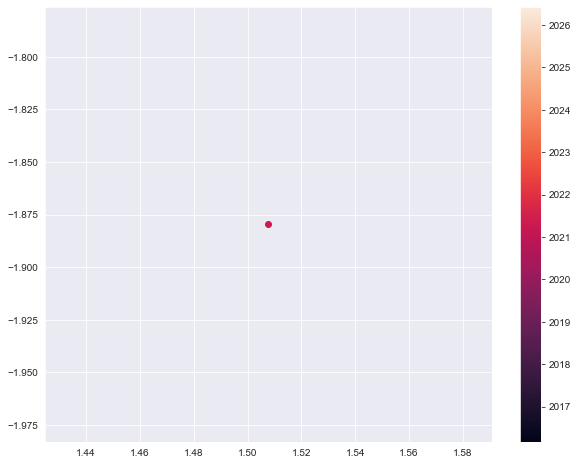

In [12]:
scaled_data=scalar.transform(df00)
pca_data=pca.transform(scaled_data)
dates=pd.date_range(start="2021-04-20",end="2021-04-22",periods=1)
t = [mdates.date2num(datetime.strptime(str(i).split(".")[0], "%Y-%m-%d %H:%M:%S")) for i in dates]
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(pca_data[:,0],pca_data[:,1], c=t[:])

loc = mdates.AutoDateLocator()
fig.colorbar(sc, ticks=loc,format=mdates.AutoDateFormatter(loc))

In [13]:
dfFinal = dfTimeSeries
dfFinal["PCA 1"] = pca_data[0:1][0][0]
dfFinal["PCA 2"] = pca_data[0:1][0][1]
dfFinal["Anomaly"] = predictiontemp[0]

In [35]:
js = dfFinal.to_json(orient = 'index')

In [37]:
print(js)

{"2021-06-07 16:00:00":{"Drive Frequency":52.9000015259,"Average Amps":38.5,"Discharge Pressure":652.4099731445,"Intake Pressure":1370.9499511719,"Intake Temperature":61.9000015259,"Motor Temperature":84.8000030518,"Drive Frequency anomaly":1,"Average Amps anomaly":1,"Discharge Pressure anomaly":-1,"Intake Pressure anomaly":-1,"Intake Temperature anomaly":1,"Motor Temperature anomaly":1,"PCA 1":1.5077568138,"PCA 2":-1.8796244174,"Anomaly":1}}
